In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.nn import ModuleList
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 데이터 불러오기

In [2]:
df = pd.read_csv("bank-direct-marketing-campaigns.csv")
print('data frame shape :', df.shape)
df.head()

data frame shape : (41188, 20)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

# 데이터 전처리

In [4]:
# 중복 제거
print('data frame shape :', df.shape)

df = df.drop_duplicates(keep='last')
print('data frame shape :', df.shape)

data frame shape : (41188, 20)
data frame shape : (39404, 20)


In [5]:
# 10대 별로 나누어 분석
df['age'] = df['age']//10
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,5,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,5,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,4,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,5,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,4,services,married,basic.9y,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
# binary variable 처리 
df = df.replace({'y':{'no':0, 'yes':1}})
df = df.replace({'pdays': {999: -1}})
df = df.replace({'contact':{'telephone':0, 'cellular':1}})
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,5,housemaid,married,basic.4y,no,no,no,0,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,5,services,married,high.school,unknown,no,no,0,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,4,admin.,married,basic.6y,no,no,no,0,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,5,services,married,high.school,no,no,yes,0,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
5,4,services,married,basic.9y,unknown,no,no,0,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


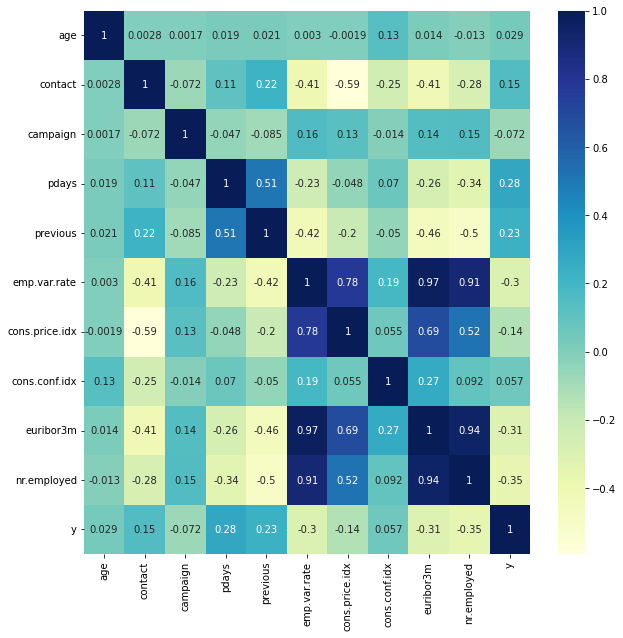

In [7]:
# 상관관계 확인
plt.figure(figsize = (10,10))
sns.heatmap(df.corr(), annot = True, cmap='YlGnBu')
plt.show()

In [8]:
# 다중공선성 변수 제거 
df.drop('nr.employed', axis=1 ,inplace=True)
df.drop('emp.var.rate', axis=1 ,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39404 entries, 0 to 41187
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             39404 non-null  int64  
 1   job             39404 non-null  object 
 2   marital         39404 non-null  object 
 3   education       39404 non-null  object 
 4   default         39404 non-null  object 
 5   housing         39404 non-null  object 
 6   loan            39404 non-null  object 
 7   contact         39404 non-null  int64  
 8   month           39404 non-null  object 
 9   day_of_week     39404 non-null  object 
 10  campaign        39404 non-null  int64  
 11  pdays           39404 non-null  int64  
 12  previous        39404 non-null  int64  
 13  poutcome        39404 non-null  object 
 14  cons.price.idx  39404 non-null  float64
 15  cons.conf.idx   39404 non-null  float64
 16  euribor3m       39404 non-null  float64
 17  y               39404 non-null 

In [9]:
# 데이터 분석에 도움되지 않는 변수 삭제
df.drop('day_of_week', axis=1 ,inplace=True)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,campaign,pdays,previous,poutcome,cons.price.idx,cons.conf.idx,euribor3m,y
0,5,housemaid,married,basic.4y,no,no,no,0,may,1,-1,0,nonexistent,93.994,-36.4,4.857,0
1,5,services,married,high.school,unknown,no,no,0,may,1,-1,0,nonexistent,93.994,-36.4,4.857,0
3,4,admin.,married,basic.6y,no,no,no,0,may,1,-1,0,nonexistent,93.994,-36.4,4.857,0
4,5,services,married,high.school,no,no,yes,0,may,1,-1,0,nonexistent,93.994,-36.4,4.857,0
5,4,services,married,basic.9y,unknown,no,no,0,may,1,-1,0,nonexistent,93.994,-36.4,4.857,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39404 entries, 0 to 41187
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             39404 non-null  int64  
 1   job             39404 non-null  object 
 2   marital         39404 non-null  object 
 3   education       39404 non-null  object 
 4   default         39404 non-null  object 
 5   housing         39404 non-null  object 
 6   loan            39404 non-null  object 
 7   contact         39404 non-null  int64  
 8   month           39404 non-null  object 
 9   campaign        39404 non-null  int64  
 10  pdays           39404 non-null  int64  
 11  previous        39404 non-null  int64  
 12  poutcome        39404 non-null  object 
 13  cons.price.idx  39404 non-null  float64
 14  cons.conf.idx   39404 non-null  float64
 15  euribor3m       39404 non-null  float64
 16  y               39404 non-null  int64  
dtypes: float64(3), int64(6), object

In [11]:
# One-Hot Encoding
df = pd.get_dummies(df, drop_first = True)
df.head()

,age,contact,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m,y,job_blue-collar,...,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success
0,5,0,1,-1,0,93.994,-36.4,4.857,0,0,...,0,0,0,0,1,0,0,0,1,0
1,5,0,1,-1,0,93.994,-36.4,4.857,0,0,...,0,0,0,0,1,0,0,0,1,0
3,4,0,1,-1,0,93.994,-36.4,4.857,0,0,...,0,0,0,0,1,0,0,0,1,0
4,5,0,1,-1,0,93.994,-36.4,4.857,0,0,...,0,0,0,0,1,0,0,0,1,0
5,4,0,1,-1,0,93.994,-36.4,4.857,0,0,...,0,0,0,0,1,0,0,0,1,0


In [12]:
df['y'].value_counts()

0    34806
1     4598
Name: y, dtype: int64

In [13]:
# train dataset, test dataset 으로 분리 + oversampling

X = df.drop('y', axis=1)
y = df['y']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X,y)

X_resampled['y'] = y_resampled
dataset = X_resampled

majority_dataset = df[df['y']==0].sample(df['y'].value_counts()[1])
minority_dataset = df[df['y']==1]

dataset = dataset[~dataset.isin(majority_dataset)].dropna()
dataset = dataset[~dataset.isin(minority_dataset)].dropna()

training_dataset = dataset
test_dataset = pd.concat([majority_dataset, minority_dataset])

X_train = training_dataset.drop(['y'],axis=1)
y_train = training_dataset[['y']]
X_test = test_dataset.drop(['y'],axis=1)
y_test = test_dataset[['y']]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60416, 46) (60416, 1) (9196, 46) (9196, 1)


# 데이터 로더

In [14]:
# train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_data = trainData(torch.FloatTensor(X_train.values)
                       , torch.tensor(y_train.values))


# test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = trainData(torch.FloatTensor(X_test.values)
                       , torch.tensor(y_test.values))


In [15]:
batch_size = 128

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

In [16]:
train_loader.dataset.X_data

tensor([[5., 0., 1.,  ..., 0., 1., 0.],
        [5., 0., 1.,  ..., 0., 1., 0.],
        [4., 0., 1.,  ..., 0., 1., 0.],
        ...,
        [5., 0., 8.,  ..., 0., 1., 0.],
        [2., 1., 1.,  ..., 0., 0., 1.],
        [7., 1., 1.,  ..., 0., 1., 0.]])

In [17]:
train_loader.dataset.y_data

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]], dtype=torch.float64)

# DNN 모델

In [18]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        
        self.in_dim = X_train.shape[1]
        self.out_dim = 1
        
        self.fc1 = nn.Linear(self.in_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, self.out_dim)

        self.relu = nn.ReLU()
        
    def forward(self, x):
        a1 = self.relu(self.fc1(x))
        a2 = self.relu(self.fc2(a1))
        a3 = self.relu(self.fc3(a2))
        a4 = self.relu(self.fc4(a3))
        logit = self.fc5(a4)
        
        return logit

In [19]:
model = BinaryClassification()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

model.parameters

<bound method Module.parameters of BinaryClassification(
  (fc1): Linear(in_features=46, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)>

In [20]:
def binary_acc(y_pred, y_test):
    y_pred_class = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_class == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

# Train

In [21]:
epochs = 200
for epoch in range(1, epochs+1):
    model.train() # 모델을 학습 모드로 변환
    epoch_loss = 0
    epoch_acc = 0
    
    for data in train_loader:
        
        # input shape : (batch_size x 45)
        inputs, labels = data
        
        optimizer.zero_grad() # gradient를 0으로 초기화
        outputs = model(inputs.float())
        
        loss = criterion(outputs, labels.float())
        acc = binary_acc(outputs, labels.float())
        
        loss.backward() # loss 역전파
        optimizer.step() # 가중치 update
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    if epoch % 10 == 0:
        print(f'Epoch {epoch+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
print('Finished Training')


Epoch 010: | Loss: 0.40549 | Acc: 80.763
Epoch 020: | Loss: 0.38983 | Acc: 81.581
Epoch 030: | Loss: 0.37955 | Acc: 82.038
Epoch 040: | Loss: 0.36898 | Acc: 82.551
Epoch 050: | Loss: 0.35410 | Acc: 83.449
Epoch 060: | Loss: 0.33721 | Acc: 84.318
Epoch 070: | Loss: 0.32201 | Acc: 85.070
Epoch 080: | Loss: 0.30643 | Acc: 86.040
Epoch 090: | Loss: 0.29361 | Acc: 86.551
Epoch 100: | Loss: 0.28114 | Acc: 87.231
Epoch 110: | Loss: 0.27091 | Acc: 87.805
Epoch 120: | Loss: 0.26504 | Acc: 87.960
Epoch 130: | Loss: 0.25565 | Acc: 88.557
Epoch 140: | Loss: 0.25028 | Acc: 88.678
Epoch 150: | Loss: 0.24343 | Acc: 89.019
Epoch 160: | Loss: 0.23974 | Acc: 89.299
Epoch 170: | Loss: 0.23276 | Acc: 89.485
Epoch 180: | Loss: 0.23112 | Acc: 89.727
Epoch 190: | Loss: 0.22275 | Acc: 90.021
Epoch 200: | Loss: 0.22279 | Acc: 90.038
Finished Training


# Test + 성능평가

In [23]:
# 모델 평가 
model.eval()

test_y_pred = torch.empty(0)
# print(test_loader.dataset.y_data.shape)

with torch.no_grad():    
    for data in test_loader: 

        inputs, labels = data
        
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        outputs = torch.round(outputs)
        outputs = outputs.squeeze(1)
        test_y_pred = torch.cat((test_y_pred, outputs))
print(classification_report(test_loader.dataset.y_data, test_y_pred, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.76      0.86      0.81      4598
         yes       0.84      0.73      0.78      4598

    accuracy                           0.80      9196
   macro avg       0.80      0.80      0.80      9196
weighted avg       0.80      0.80      0.80      9196

